In [16]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>''')

In [484]:
HTML('''
<style>
    .yourDiv {position: fixed;top: 100px; right: 0px; 
              background: white;
              height: 100%;
              width: 175px; 
              padding: 10px; 
              z-index: 10000}
</style>
<script>
function showthis(url) {
	window.open(url, "pres", 
                "toolbar=yes,scrollbars=yes,resizable=yes,top=10,left=400,width=500,height=500");
	return(false);
}
</script>

<div class=yourDiv>
    <h4>MENU</h4><br>
    <a href=#Data>1. Data</a><br>
    <a href=#FoodFeedOtherAcross>2. Spatial Coverage</a><br>
    <a href=#FoodFeedOtherWithin>3. Temporal Coverage</a><br><br>

    <a href="javascript:code_toggle()">Toggle Code On/Off</a><br>
    <a href=#Top>Top</a><br>
    <a href=#LeftOff>Left Off Here</a><br>
</div>
''')

<a name="Top"></a>
<center>
## General Results


This page overviews our general results. 

The main findings are that in our sample of 58 countries, farms < 2 ha produce 8% of the total food supply, while farms < 50 ha produce 41% of the total food supply. The largest differences (in terms of effect size) in the amount of food produced were between the very large farm and the smallest farm categories in terms of how much food each produced. 68% of all the food came from 20 to 100 ha and 200 to 1000 ha farm sizes.

This study also measures what percentage of each farm size class's crop producion goes towards food, feed, processing, seed, waste, or other. The farm size category with the largest percentage of food produced compared to other cateogories within thier farm size group, are from 100 to 1000 ha, where 70% of thier crop production goes towards food.

55% of crop production on farms < 2 ha goes towards food, while 16% goes towards feed, and the remainder either goes towards other, waste, processing, or seed (respectively). 

The farm size contributing to the largest amount of food waste (post-harvest loss, not consumer based food waste) are farms between 50-100 ha.

In [50]:
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import copy
import matplotlib.gridspec as gridspec
from collections import OrderedDict
from pivottablejs import pivot_ui  # python setup.py install --user
%matplotlib inline


In [51]:
def read_data(path):

    data = pd.read_csv(path, low_memory=False)
    data['Farm_Sizes'] = pd.cut(data['fs_class_max'],
                                bins=[0, 1, 2, 5, 10, 20, 50,
                                      100, 200, 500, 1000, 100000])
    
    global variables
    variables = OrderedDict([('Farm_Sizes', 'Farm_Sizes'),
                             ('production_Food_kcal', 'Food'),
                             ('production_Feed_kcal', 'Feed'),
                             ('production_Seed_kcal', 'Seed'),
                             ('production_Waste_kcal', 'Waste'),
                             ('production_Processing_kcal', 'Processing'),
                             ('production_Other_kcal', 'Other')])

    data = data.loc[:, variables.keys()]
    data.columns = variables.values()

    return data

In [52]:
def piv(data, func=np.nansum):

    pivot = pd.pivot_table(data,
                           index=['Farm_Sizes'],
                           values=variables.values()[1:],
                           aggfunc=func)

    return pivot

In [53]:
def perc(data, how='within'):

    if how is 'within':

        pivot = piv(data)
        pivot = pivot.transpose()

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()


    elif how is 'cumsum':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        pivot = pivot.cumsum(axis=0)

        return pivot


    elif how is 'across':

        pivot = piv(data)

        for variable in pivot.columns:
            pivot[variable] = pivot[variable] / pivot[variable].sum()

        return pivot.transpose()

    else:

        print 'Require how argument'

In [480]:
df_within

,Feed,Food,Other,Processing,Seed,Waste
Farm_Sizes,,,,,,
"(0, 1]",0.237441,0.557491,0.116235,0.023644,0.016697,0.048493
"(1, 2]",0.078022,0.528437,0.246586,0.069265,0.024367,0.053323
"(2, 5]",0.188993,0.505486,0.151104,0.072839,0.030516,0.051062
"(5, 10]",0.159973,0.484746,0.114886,0.150468,0.037205,0.052721
"(10, 20]",0.159772,0.480801,0.073849,0.201936,0.035844,0.047798
"(20, 50]",0.163737,0.459236,0.055698,0.249785,0.033665,0.037880
"(50, 100]",0.152403,0.472618,0.055224,0.244229,0.033991,0.041535
"(100, 200]",0.114567,0.643168,0.032773,0.106484,0.037614,0.065394
"(200, 500]",0.119055,0.710868,0.016772,0.054654,0.055964,0.042686


In [481]:
def plot_stacked_bar(data, how='within', fig_=True, ax=None):

    txt1 = ['Feed', 'Food', 'Other', 'Processing', 'Seed', 'Waste']
    txt2 = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
            '20 to 50', '50 to 100', '100 to 200', '200 to 500',
            '500 to 1000', '> 1000']
    txt3 = ['< 1', '2 to 5', '10 to 20', '50 to 100', '200 to 500', '> 1000']

    if how is 'within':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt2)
        cmap = cm.get_cmap('Set3')
        kind = 'bar'

    elif how is 'across':

        legend_txts = copy.copy(txt2)
        labels_txts = copy.copy(txt1)
        cmap = cm.get_cmap('YlGnBu')
        kind = 'bar'

    elif how is 'cumsum':

        legend_txts = copy.copy(txt1)
        labels_txts = copy.copy(txt3)
        cmap = cm.get_cmap('Set3')
        kind = 'area'
    
    else:
        pass
    
    if fig_ is True:
        
        fig = plt.figure(figsize=[10, 5], facecolor='white')
        ax = fig.add_subplot(111)
    
    else:
        pass

    data.plot(kind=kind,
              stacked=True,
              cmap=cmap,
              alpha=0.9,
              linewidth=0,
              grid=False,
              ax=ax)
    
    # Axis main
    ax.set_axis_bgcolor("#d6d7e5")
    ax.set_clip_on(False)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Legend
    legend_txts_r = copy.deepcopy(legend_txts)
    legend_txts_r.reverse()
    handles, labels = ax.get_legend_handles_labels()
    legend = ax.legend(handles[::-1], labels[::-1],
                       loc='center left',
                       frameon=1,
                       bbox_to_anchor=(1, 0.5))

    for i in xrange(len(legend_txts_r)):
        legend.get_texts()[i].set_text(legend_txts_r[i])

    frame = legend.get_frame()
    frame.set_color('white')

    # Axis particulars
    ax.set_xticklabels(labels_txts)
    ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)

    if how is 'within':
        ax.set_xlabel('Farm Sizes (ha)')
        ax.set_ylabel('Percentage\n')
        ax.set_ylim([0, 1])
        ax.set_title('Type of production per farm size\n', fontsize=12)

    elif how is 'across':
        ax.set_xlabel('Category')
        ax.set_ylabel('Percentage\n')
        ax.set_ylim([0, 1])
        ax.set_title('Type of production across farm size\n', fontsize=12)
        
    elif how is 'cumsum':
        ax.set_xlabel('Farm Sizes (ha)')
        ax.set_ylabel('Percentage\n')
        ax.set_title('Type of production per farm size: Cumulative\n', fontsize=12)

    if fig_ is True:
        return plt.show()

    else:
        return ax


In [55]:
PATH = '/Users/Vinny_Ricciardi/Documents/Data_Library_Big/Survey/Global/Farm_Size/Data/FarmSize_data_fullyProcessed.csv'
df = read_data(PATH)

In [466]:
df_within = perc(df, how='within')
df_across = perc(df, how='across')
df_cumsum = perc(df, how='cumsum')
df_raw = piv(df)

In [467]:
tmp1 = df_within.copy()
tmp1['Type'] = 'Within'

tmp2 = df_across.copy()
tmp2 = tmp2.transpose()
tmp2['Type'] = 'Across'

tmp3 = df_cumsum.copy()
tmp3['Type'] = 'Cumsum'

tmp4 = df_raw.copy()
tmp4['Type'] = 'Raw'

tmp = pd.concat([tmp1, tmp2, tmp3, tmp4])
tmp = tmp.reset_index()
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace('(', '')
tmp['Farm_Sizes'] = tmp['Farm_Sizes'].str.replace(']', '')

<a name="Data"></a>
<h2>Data</h2><br>

Here is a [link](https://vinnyricciardi.github.io/farmsize_site/Html/pivottablejs) to an interactive pivot table so you can explore the data. Use 'type' to change whether you are looking at the percentage of crop produced for each category 'within' a farm size group, 'across' groups, via a 'cumulative' percentage across groups, or raw kcal produced. Use the dropdown labeled 'Food' to recalculate based on another production category. 

The default setting shows a heatmap for which farm size classes have the highest food production (kcal/person) per category. The 500 to 1000 farm size class makes up 52% of all food production in our dataset, which accounts for 73% of this group's total crop production.

The three charts below were derived from the pivot table.

In [58]:
# pivot_ui(tmp)  # Enable for pivot table interactivitity within this Jupyter notebook

<a name="FoodFeedOtherAcross"></a>
<h2>Food Feed Other by Farm Size</h2><br>

This plot shows the percentage that each farm size contributes to each category (e.g., food, feed, other, etc.) For example, farms under 1 ha produce 5% of the total food supply in our sample.

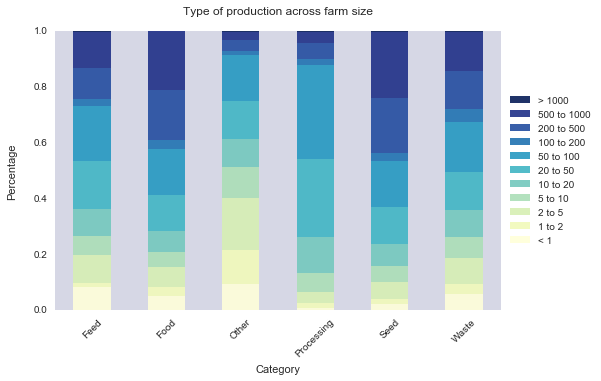

In [482]:
plot_stacked_bar(df_across, how='across', fig_=True)

This plot also shows the percentage that each farm size contributes to each category but in cumulative percentages. For example, farms under 2 ha produce 8% of the total food supply in our sample and farms 20 ha and under produce 48% of the total food supply in our sample. Again, here is a [link](https://vinnyricciardi.github.io/farmsize_site/Html/pivottablejs) to an interactive pivot table so you can explore the data in more detail.

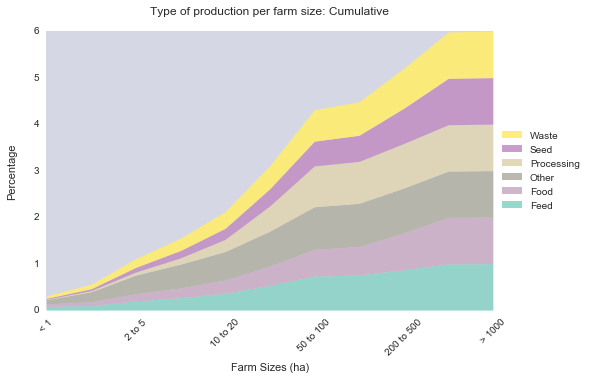

In [478]:
plot_stacked_bar(df_cumsum, how='cumsum', fig_=True)

In [452]:
def factor_plot(data, id_var='Farm_Sizes'):
    
    data = pd.melt(data, id_vars='Farm_Sizes')
    data = data.loc[data['value'] > 0.5] 
    data['log'] = np.log(data['value'])
    
    fs_order = ['(0, 1]', '(1, 2]', '(2, 5]', '(5, 10]', 
                '(10, 20]', '(20, 50]', '(50, 100]', '(100, 200]', '(200, 500]',
                '(500, 1000]', '(1000, 100000]']
    
    if id_var is 'Farm_Sizes':
        
        col = 'variable'
        x = 'Farm_Sizes'
        y = 'log'
        order = fs_order

    else:
        
        data = data.sort('Farm_Sizes')
        data['Farm_Sizes'] = pd.Categorical(data['Farm_Sizes'], fs_order)
        data = data.sort('Farm_Sizes')
        col = 'Farm_Sizes'
        x = 'variable'
        y = 'log'
        order = None

    g = sns.factorplot(x=x, y=y,
                       col=col, 
                       data=data,
                       kind='box',
                       col_wrap=2,
                       color='#55a868',
                       fliersize=1,
                       aspect = 1.5,
                       order=order)

    g.fig.subplots_adjust(wspace=0.2, hspace=0.3)

    titles = data.variable.unique()
    
    fs_txt = ['< 1', '1 to 2', '2 to 5', '5 to 10', '10 to 20',
              '20 to 50', '50 to 100', '100 to 200', '200 to 500',
              '500 to 1000', '> 1000']
    
    if id_var is 'Farm_Sizes':
        
        for ax, title in zip(g.axes.flat, titles):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(fs_txt)
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nFarm Sizes (ha)')
        
    else:
        
        for ax, title in zip(g.axes.flat, fs_txt):
            
            ax.set_title(title)
            ax.set_ylabel('Production \n ln (kcal)')
            ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.set_xlabel('\nPoduction Category')


In [92]:
number_of_records = len(df)

In order to better understand whether there are differences between the farm size groups, these boxplots show the total amount of crops produced (in logged kcal for standardization). Across all production categories (e.g., food, feed, other, etc.) there are no visual differences in the means and confidence intervals. But, there are (a) a lot of outliers in each plot that indicate high variance, and (b) since our sample is very large (58 countries which comprise of {{number_of_records}} total records due to subnational units and crop types) we cannot use p-values to determine significance.

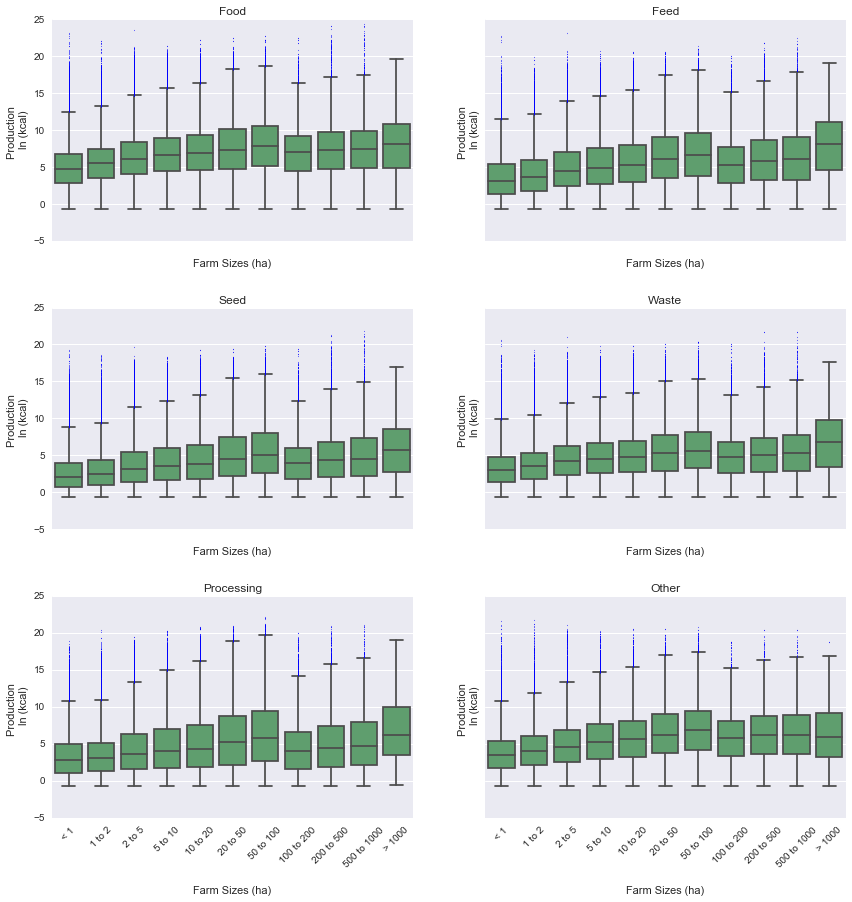

In [424]:
factor_plot(df, id_var='Farm_Sizes')

To circumvent the large dataset issue, the effect size was used to determine differences between farm sizes rather than statistical significance. Cohen's d was calculated via taking the (mean of farmsize 1 - mean of farmsize 2) / (standard deviation of farmsize 1) then taking the absolute value. The relative significance was calculated by thresholds according to [Sullivan and Feinn 2012](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3444174/).

Where the Cohen d's effect size values correspond to percent non-overlapping observations, as in:

| Relative Size 	| Effect Size 	| Percentile 	| % of Non- overlap 	|
|---------------	|:-------------:|:-----------:	|:-------------------:	|
|               	|      0      	|     50    	|         0         	|
| Small         	|     0.2     	|     58    	|         15        	|
| Medium        	|     0.5     	|     69    	|         33        	|
| Large         	|     0.8     	|     79    	|         47        	|
|               	|     1.0     	|     84    	|         55        	|
|               	|     1.5     	|     93    	|         71        	|
|               	|     2.0     	|     97    	|         81        	|

In [418]:
def cohens_d(data1, data2, how='within'):

    cols = data1.columns
    check = []
    
    for i in xrange(0, len(cols)):
        
        for j in xrange(1, len(cols)):
            
            col_name = str(cols[i]) + '_' + str(cols[j])
            col_name_r = str(cols[j]) + '_' + str(cols[i])

            if col_name in check:
                
                pass

            elif cols[i] is cols[j]:
                
                pass

            else:
                
                data1[col_name] = ((data1[cols[i]] - data1[cols[j]]) / data2[cols[i]]).abs()
                check.append(col_name)
                check.append(col_name_r)

    data = data1.iloc[:, len(cols):]

    data = data.reset_index()

    if how is 'within':
        
        data = pd.melt(data, id_vars='Farm_Sizes', value_name='cohens_d')

    else:
        
        data = pd.melt(data, id_vars='index', value_name='cohens_d')
        
    data['cohens_d_level'] = np.where(data['cohens_d'] <= 0.2, 'small',
                                      np.where(data['cohens_d'] >= 0.8, 'large',
                                               'medium'))

    return data

Here are the results:

In [436]:
data = df.copy()
data['Farm_Sizes'] = data['Farm_Sizes'].astype(str)
means = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanmean)
sds = pd.pivot_table(data, columns='Farm_Sizes', aggfunc=np.nanstd)
out = cohens_d(means, sds, how='across')
out = out.loc[out['cohens_d_level'] == 'large']
out['Farm_Sizes'] = out['Farm_Sizes'].str.replace(']', ')')
out['Farm_Sizes'] = out['Farm_Sizes'].str.replace('_', ' and ')
out.columns = ['Category', 'Farm sizes compared', 'Cohens d', 'Relative effect size']
out.sort('Cohens d')

,Category,Farm sizes compared,Cohens d,Relative effect size
109,Food,"(1, 2) and (500, 1000)",0.848607,large
157,Food,"(10, 20) and (500, 1000)",0.879428,large
94,Seed,"(1, 2) and (200, 500)",0.911315,large
57,Processing,"(0, 1) and (500, 1000)",0.987951,large
239,Waste,"(1000, 100000) and (500, 1000)",1.111736,large
292,Seed,"(20, 50) and (500, 1000)",1.119664,large
160,Seed,"(10, 20) and (500, 1000)",1.220897,large
58,Seed,"(0, 1) and (500, 1000)",1.415773,large
108,Feed,"(1, 2) and (500, 1000)",1.433436,large
51,Processing,"(0, 1) and (50, 100)",1.441876,large


In [450]:
tmp = pd.DataFrame(pd.pivot_table(out, index='Farm sizes compared', aggfunc='count').max(axis=1)).sort(0)
tmp = tmp.reset_index()
tmp.columns = ['Farm sizes compared', 'Count of large effect size']
tmp

,Farm sizes compared,Count of large effect size
0,"(0, 1) and (50, 100)",1
1,"(1, 2) and (200, 500)",1
2,"(2, 5) and (500, 1000)",1
3,"(20, 50) and (500, 1000)",1
4,"(0, 1) and (500, 1000)",2
5,"(10, 20) and (500, 1000)",2
6,"(1000, 100000) and (200, 500)",2
7,"(5, 10) and (500, 1000)",2
8,"(1, 2) and (500, 1000)",3
9,"(1000, 100000) and (500, 1000)",3


In [451]:
tmp = pd.DataFrame(pd.pivot_table(out, index='Category', aggfunc='count').max(axis=1)).sort(0)
tmp = tmp.reset_index()
tmp.columns = ['Category', 'Count of large effect size']
tmp

,Category,Count of large effect size
0,Feed,1
1,Waste,1
2,Processing,2
3,Food,5
4,Seed,9


From this we can see that there was the most differences between the (1, 2) and (500, 1000) farm size classes and (1000, 100000) and (500, 1000) farm size classes. For all farm size classes, the majority of differences were in the amount of seed and food production.

<a name="FoodFeedOtherWithin"></a>
<h2>Food Feed Other within Farm Size Groups</h2><br>

This plot shows the percentage of Food, Feed, Seed, Waste, Processing, and Other for each farm size category. For example, 56% of crop production for  farms under 1 ha is food, while 6% of their crop production is waste.

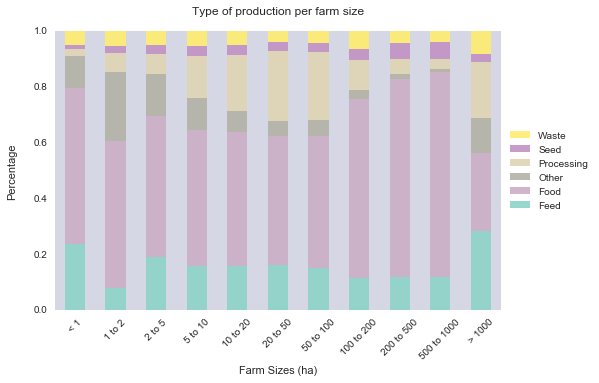

In [479]:
plot_stacked_bar(df_within, how='within', fig_=True)

These plots compare crop production within each farm size class:

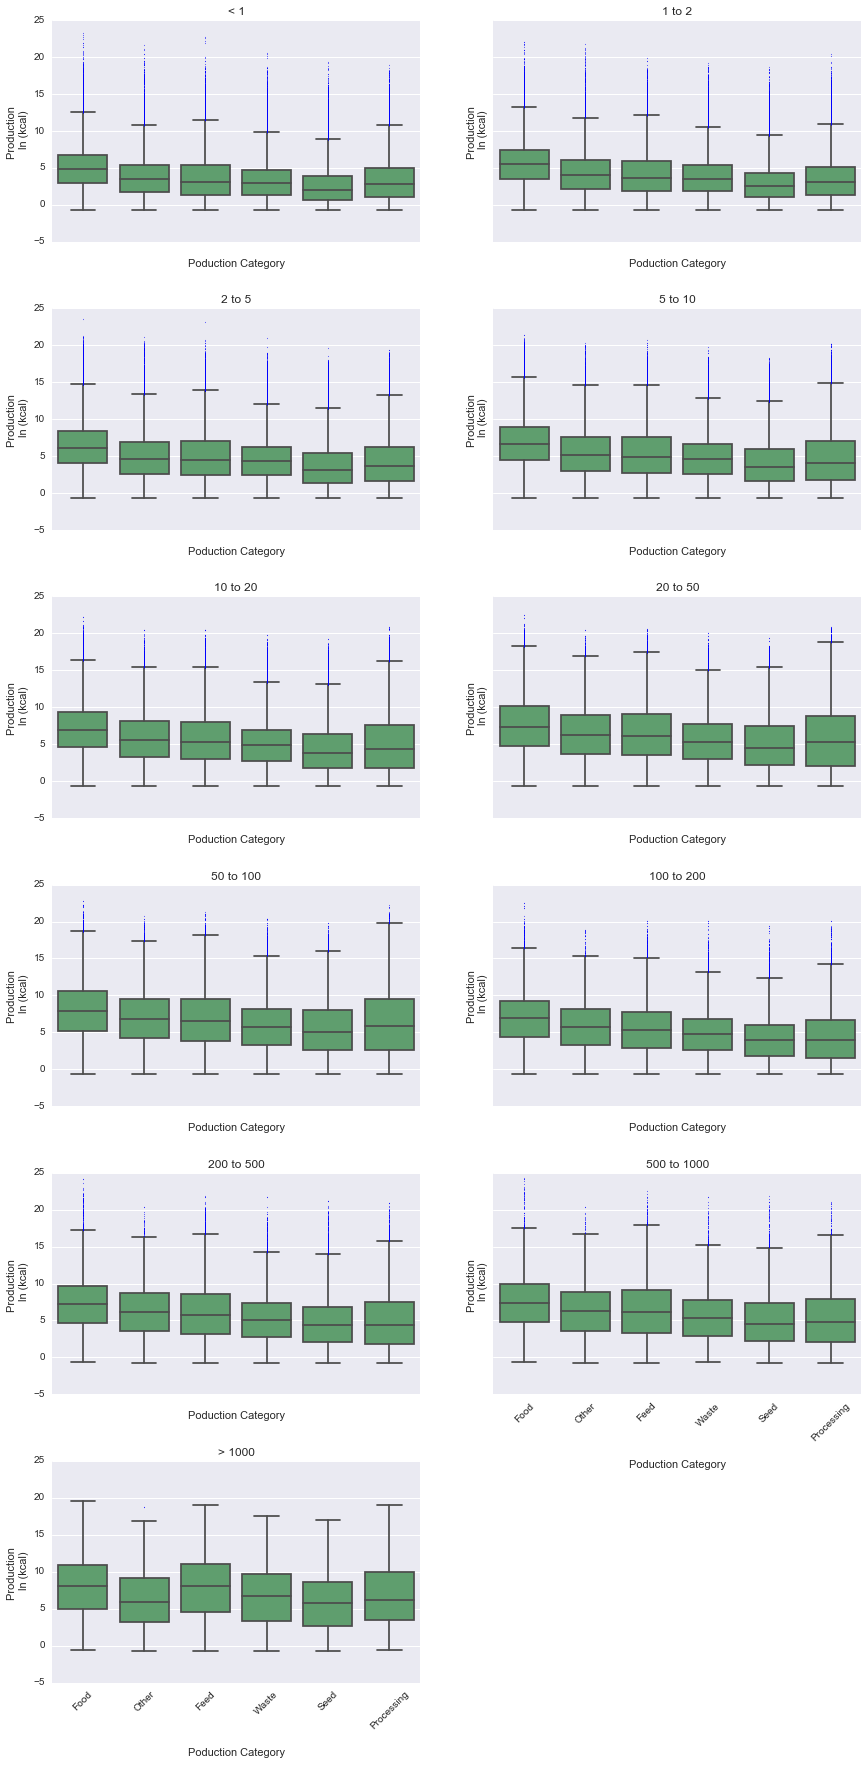

In [453]:
factor_plot(df, id_var='variable')

We calculate the effect size for the differences within each farm size group, but across production cateogries (e.g., food, feed, other).
There were only medium differences in effect size when looking at how each farm size group allocated their production.

In [457]:
means = pd.pivot_table(df, index='Farm_Sizes', aggfunc=np.nanmean)
sds =  pd.pivot_table(df, index='Farm_Sizes', aggfunc=np.nanstd)
out = cohens_d(means, sds, how='within')
out = out.loc[out['cohens_d_level'] != 'small']

out['Farm_Sizes'] = out['Farm_Sizes'].str.replace(']', ')')
out['variable'] = out['variable'].str.replace('_', ' and ')
out.columns = ['Farm sizes', 'Categories commpared', 'Cohens d', 'Relative effect size']
out.sort('Cohens d')

,Farm sizes,Categories commpared,Cohens d,Relative effect size
1,"(1, 2)",Feed and Food,0.200763,medium
7,"(100, 200)",Feed and Food,0.236428,medium
8,"(200, 500)",Feed and Food,0.263749,medium
9,"(500, 1000)",Feed and Food,0.266787,medium


<a name="Global Estimates"></a>
<h2>Global Estimates</h2><br>


In [486]:
data = df.copy()

In [487]:
data.head()

,Farm_Sizes,Food,Feed,Seed,Waste,Processing,Other
0,"(1, 2]",NaN,NaN,NaN,NaN,NaN,NaN
1,"(20, 50]",NaN,NaN,NaN,NaN,NaN,NaN
2,"(20, 50]",0.0,0.0,0.0,0.0,0.0,0.0
3,"(50, 100]",0.0,0.0,0.0,0.0,0.0,0.0
4,"(20, 50]",0.0,0.0,0.0,0.0,0.0,0.0


<a name="LeftOff"></a>
<h3>Left Off</h3>

To Do:
- Need to calculate bootstraps and jackknife estimates